#  Supervised Classification of Fruit Fly Neuromuscular Junction Identity With KNN
## By Adama Berndt



The goal of this project was to take fruit fly neuromuscular junction synapses that have been immunostained with the post-synaptic marker DLG and qunatified with the NMJ morphometrics plugin in Fiji(https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004823), and then use these measurements to fit a K-Nearest Neighbors Algorithm in order to identify synapses that belong to neuronal populations of interest, eventually in an automated or semi-automated fashion.  

See Presentation Link for stained images of fruit fly synapses
https://docs.google.com/presentation/d/1rNDQhQU3V1z_7FC5m2SVBMRogGKEZ5-Bk0zxHTsn5CA/edit?usp=sharing



In [24]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [25]:
!pip install -U pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


Merging of all NMJ Morphometrics Text Files

In [0]:
#NMJ Morphometrics plugin in FIJI outputs files for each synapse as result.txt so result.txt(1)-result.txt(123) get merged here and then imported to excel and saved as CSV
import fileinput
import glob

file_list = glob.glob("*.txt")

with open('resultnewvglutccapr.txt', 'w') as file:
    input_lines = fileinput.input(file_list)
    file.writelines(input_lines)
    


#Dataset Description

After filtering of muscles with insufficient sample size due to prep damage or developmental differences our dataset featured ultimately 10 classes and 123 total synapse measurements. Each synapse had 7 usable features, keep in mind that # Active zones is a non-functional vestigial element of the NMJ morphometrics plugin, it is automatically selected out with feature selection later in the project.  

1.Area
2.Perimeter
3.Length
4.Longest branch length
5.#Branches
6.#Branching points
7.#Islands
8.#Active zones

#KNN Code 

For this train test split the accuracy score was  0.04
GridSearch found optimal number of neighbors: 1
Mean CV test scores are: [0.38461538 0.15384615 0.26923077 0.15384615 0.19230769 0.15384615
 0.11538462 0.07692308 0.07692308 0.15384615]


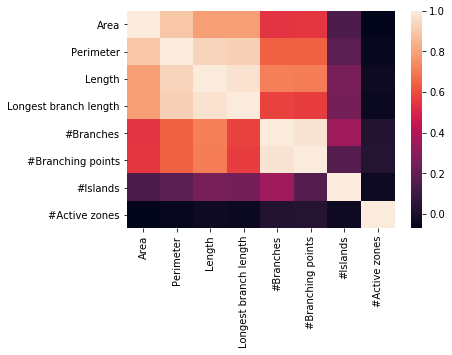

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np





summary = pd.read_csv('All results with labels update limit.csv')

#print(summary)
y = summary['Synapse#']

#print(y.shape)
X = summary.drop(columns = 'Synapse#')

#print(X)

#Correlation plot allows us some ability to interpret our feature selection by looking at which features have more or less variance.

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm').set_precision(2)
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    

plot_corr(X)
normalize(X) #Creates a common scale between features
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)

#This transform allows us to do feature selection for a more sparse but salient set of predictive information
X_new = model.transform(X) 

#Allows us to see for different splits how the predictive ability changes and how this dataset may be better at predicting specific muscles.
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2) # 80% training and 20% test
knn = KNeighborsClassifier(n_neighbors=2, algorithm = 'auto')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('For this train test split the accuracy score was ', accuracy_score(y_test, y_pred))
#print(y_test)
#print(y-pred) 
#Use the two print functions commented out above to see the exact muscles the model gets right and wrong

#Stratified K fold preserves representation for each of our muscles in the training and test datasets  
cv = StratifiedKFold(n_splits=4)
knn = KNeighborsClassifier()
scores = cross_validate(knn, X, y, cv=cv,
                         scoring=('accuracy', 'f1_micro'),
                         return_train_score=True)
#pprint.pprint(scores)

#Nested CV in this case is used for us to test our k hyperparameter
p_grid = {
    "n_neighbors": [1,2,3,4,5,6,7,8,9,10] #Because I only had a max of 14 samples per synapse I didn't try a k above 10.
}

inner_cv_iterator = ShuffleSplit(n_splits=2, random_state=10)
outer_cv_iterator = StratifiedKFold(n_splits=2, shuffle=True, random_state=10)


grid_search = GridSearchCV(estimator=knn, param_grid=p_grid, cv=inner_cv_iterator)
cross_val_score(estimator=grid_search, X=X, y=y, cv=outer_cv_iterator, scoring='accuracy')


grid_search.fit(X, y)
best = grid_search.best_params_
cv = grid_search.cv_results_

print('GridSearch found optimal number of neighbors:', best['n_neighbors'])
print('Mean CV test scores are:', cv['mean_test_score'])


 



SVC

In [21]:
#Quick check to see how SVC performs, not well
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

summary = pd.read_csv('All results with labels update limit.csv')
y = summary['Synapse#']
X = summary.drop(columns = 'Synapse#')
normalize(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 90% training and 10% test


clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 

print(clf.predict(X_test))
print(y_test)

[13 13 13 13 13 13 13 13 13 13 13 13 13]
78     12
34      3
28      3
59      8
85     12
16      2
54      8
102    15
14      2
35      3
58      8
8       1
52      8
Name: Synapse#, dtype: int64


PCA

(123, 9)
Explained variation per principal component: [0.97007246 0.02674863]


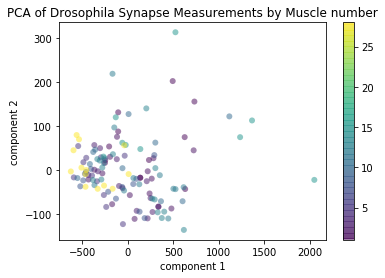

In [22]:
#Due to the poor predictive power of the models, I was curious to see how the data plots when dimensionality is reduced, unsurprisingly muscle groups do not seperate well
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA

summary = pd.read_csv('All results with labels update limit.csv')

#print(summary)
y = summary['Synapse#']

#print(y.shape)
X = summary

normalize(X)
#PCA allows us to reduce the dimensionality of our data and see how different muscles group
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print(X.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.5) 
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.title('PCA of Drosophila Synapse Measurements by Muscle Number')
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))







TSNE

Text(0.5, 1.0, 't-SNE of Drosophila Synapse Measurements by Muscle Number')

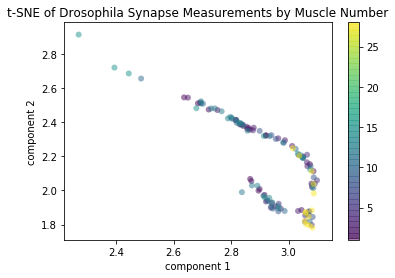

In [23]:
#Muscle groups do not separate well for TSNE either
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA


summary = pd.read_csv('All results with labels update limit.csv')

#print(summary)
y = summary['Synapse#']

#print(y.shape)
X = summary
normalize(X)
#t-SNE is a more versatile way for us to visualize our dataset components with reduced dimensionality that uses a t-distribution to get new coordinates.
X_TSNE = TSNE(n_components=2, n_iter = 1000, perplexity=120).fit_transform(X) #attempted at multiple perplexities and iteration numbers


plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1],c=y, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.title('t-SNE of Drosophila Synapse Measurements by Muscle Number')

TruncatedSVD 

Text(0.5, 1.0, 'TruncatedSVD of Drosophila Synapse Measurements by Muscle')

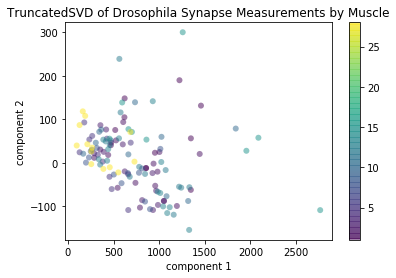

In [19]:
#Tried TruncatedSVD as it is supposed to be better for sparser datasets
from sklearn.decomposition import TruncatedSVD
summary = pd.read_csv('All results with labels update limit.csv')

X = summary
TSVD = TruncatedSVD(n_components=2)
TSVD.fit(X)
X_TSVD = TSVD.transform(X)

plt.scatter(X_TSVD[:, 0], X_TSVD[:, 1],c=y, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.title('TruncatedSVD of Drosophila Synapse Measurements by Muscle Number')



CNN

Based on the output results of these component analyses a large proportion of the variance is contained in the first principle component, but muscle classes do not group differently along the axis of the first component, therefore the variance contained in the data is probably not helpful for
distinguishing these muscles at least at this sample size and perhaps not with these particular metrics. 

Using the NMJ morphometrics plugin with immunohistochemical data may not give the resolution or features required to tell the different synapses apart. 
Given this, I think the best next step would be to build a CNN, but unfortunately, I don't have a dataset yet that will work with this task in the given time period. 

Unfortunately a large bulk of my working time went into troubleshooting the Morphometrics plugin, but I made sure to try a variety of algorithmic approaches and I look forward to applying more approaches as I continue to build my dataset. 

#Thank you for your time!


